## RQ 1 & 2 & 3: Model Performance (Pass@K)

In [1]:
import json
import os
import re
from data_process import read_problems, stream_jsonl
from code_analysis import remove_print_content, clean_code
from collections import defaultdict

In [2]:
data_folder = 'data'

years_in_interest = [ 'year2018', 'year2019', 'year2020', 'year2021', 'year2022', 'year2023', 'year2023-oct', 'humaneval', 'codereval', 'refactor_if', 'refactor_loop', 'refactor_var-renamer', 'refactor_param', 'refactor_fn-decorator']
model_in_interest = ['CodeLlama-7b-Instruct', 'starcoder-instruct', 'starCoder-chat', 'WizardCoder-instruct', 'Phind-instruct', 'chatglm2', 'gpt-3.5-turbo-0613', 'copilot']
task_in_interest = ['infill']

result = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))

# set K here
topk = 1

for year in years_in_interest:
    for model_name in model_in_interest: # , 'Phind'
        for task in task_in_interest:

            complete_match = 0
            
            answer_file = f'../{data_folder}/{task}_{year}/model_answer/{model_name}.jsonl'
            
            try:
                gen_answer = {task['question_id']: task for task in stream_jsonl(answer_file)}
            except FileNotFoundError as e:
                result[task][model_name][year]['complete_match'] = -1
                result[task][model_name][year]['complete_match_ratio'] = -1
                continue

            # read question
            question = {task['question_id']: task for task in stream_jsonl(f'../{data_folder}/infill_{year}/question.jsonl')}

            for question_id in question:
                for k in range(topk):
                    try: 
                        raw_answer = gen_answer[question_id]['choices'][k]['turns'][0]
                    except:
                        continue
                    
                    cleaned_content = clean_code(question[question_id]['content'])
                    cleaned_question = clean_code(question[question_id]['turns'][0][0])
                    
                    groundtruth = cleaned_content.replace(cleaned_question, '').strip()
                    
                    groundtruth = remove_print_content(groundtruth)
                    raw_answer = remove_print_content(raw_answer)
                    
                    assert '\n' not in groundtruth, f'groundtruth has multiple lines: {question_id}, year: {year}\n{cleaned_content}\n{groundtruth}'
                    assert len(groundtruth.strip()) > 0, f'groundtruth is empty: {question_id}'
                    
                    if len(raw_answer.split('\n')) == 1:
                        last_state = groundtruth.split('\n')[-1]
                        if last_state in raw_answer:
                            complete_match += 1
                            break
                        
                    if groundtruth in raw_answer:
                        complete_match += 1
                        break
                
            result[task][model_name][year]['complete_match'] = complete_match
            result[task][model_name][year]['complete_match_ratio'] = round(complete_match / len(question) * 100, 1)
            

In [3]:

metrics = 'complete_match_ratio' 
task = 'infill'

table = [['model'] + [x.replace('refactor_', '') for x in years_in_interest]]
for model_name in result[task]:
    row = [model_name.lower().rstrip('-instruct')]
    
    for year in years_in_interest:
        row.append(result[task][model_name][year][metrics])
    
    table.append(row)
print(task, topk)
for row in table:
    fmtstr = '   '.join(['{:>15}'] * len(row))
    print(fmtstr.format(*row))
    print('-' * 200)
print()
            

infill 1
          model          year2018          year2019          year2020          year2021          year2022          year2023      year2023-oct         humaneval         codereval                if              loop       var-renamer             param      fn-decorator
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
   codellama-7b              37.0              37.2              37.0              38.5              33.6              38.0              43.2              53.0              52.2              35.1              41.8              38.2              37.3              23.4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
       starcode              30.7              30.5  

In [4]:
# write to tsv
os.makedirs(f'../Result/performance', exist_ok=True)
tsv_path = os.path.join('../Result/performance/', '{}_full_{}.tsv'.format(task, topk))

with open(tsv_path, 'w') as f:
    for row in table:
        f.write('\t'.join([str(x) for x in row]) + '\n')

print('write to', tsv_path)

write to ../Result/performance/infill_full_1.tsv


## Assumption for RQ1-3 (Code Similarity)

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np

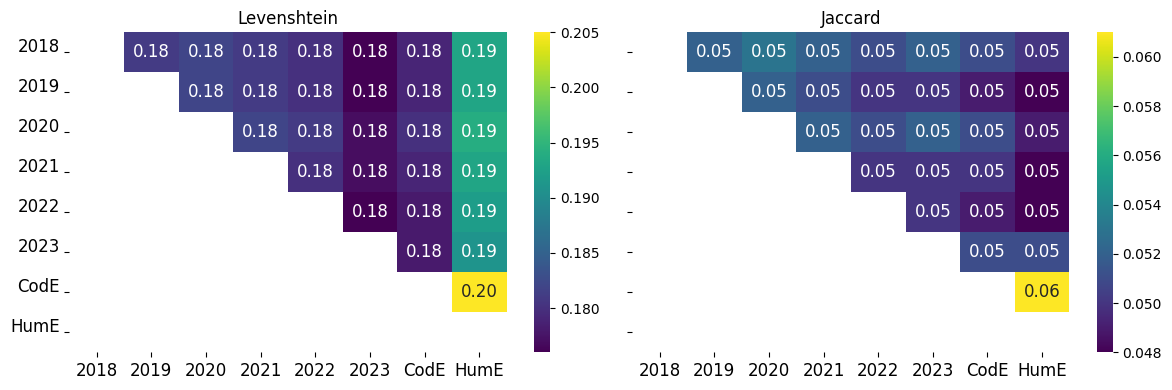

In [6]:
# Create the figure and subplots
col = 2
row = 1
fig, axes = plt.subplots(row, col, figsize=(col * 6, row * 4), sharex=True, sharey=True)

time_spots = ['2018', '2019', '2020', '2021', '2022', '2023', 'CodE', 'HumE']
simi_dict = {'codebleu': 'CodeBleu', 'sed': 'Levenshtein', 'jaccard': 'Jaccard'}

cur_axis = 0
sim_dir = "../Result/similarities-all/"
cmap_list = ['viridis'] * len(simi_dict)

simi_order = ['sed','jaccard']  #'codebleu', 


for i, simF in enumerate(simi_order):
    data = pd.read_csv(os.path.join(sim_dir, '{}.tsv'.format(simF)), sep="\t")
    
    # Because codeblue values are too small, so we multiply 100 to make it more visible
    if 'codebleu' in simF.lower():
        data = data * 100 
        
    data = data.iloc[:,1:]
    data = data.round(3) # round to 3 decimal places
    
    dataplot = sb.heatmap(data, cmap='viridis', annot=True, annot_kws={"fontsize":12}, fmt=".2f", ax=axes[i]) # , vmax=1, vmin=0

    # set y axis labels 
    dataplot.set_yticks(np.arange(len(time_spots))+0.5, labels=time_spots, fontsize=12, va="baseline", rotation=0, position=(0,3))
    dataplot.set_xticks(np.arange(len(time_spots))+0.5, labels=time_spots, fontsize=12, rotation=0)
    
    dataplot.set_title(simi_dict[simF])
    cur_axis += 1

# Adjust spacing between subplots
fig.tight_layout()

# displaying heatmap
plt.savefig('../Figure/rq-similarity-all.png')

## RQ4 - MIA-related Scores

In [7]:
import matplotlib.pyplot as plt
from data_process import load_jsonl
from matplotlib.lines import Line2D

In [8]:
metrics = ['ppl', 'ppl_lower', 'ppl/zlib', 'Min_5.0% Prob', 'Min_10.0% Prob', 'Min_20.0% Prob'] #, 'Min_30.0% Prob', 'Min_40.0% Prob'] #'ppl/lowercase_ppl',]
iter_list = ['year2018', 'year2019', 'year2020', 'year2021', 'year2022', 'year2023', 'humaneval', 'codereval', 'refactor_if', 'refactor_loop', "refactor_var-renamer", "refactor_param", "refactor_fn-decorator"]



In [9]:
# calculate
import math
data = []

data_folder = 'data'
model = 'starcoder-instruct'
# model = 'CodeLlama-7b'
# model = 'wizardCoder'

for m in metrics:
    print('calculating', m)
    plot_data = []
    
    for iter_item in iter_list:
        records = load_jsonl(f'../{data_folder}/infill_{iter_item}/model_score/{model}.jsonl', key_str='hexsha')

        per_year = []
        for r in records:
            per_year.append(r['pred'][m])
        # print(len(per_year))
        if len(plot_data) > 0:
            assert per_year != plot_data[-1]
        per_year = [x for x in per_year if not math.isnan(x)]
        plot_data.append(per_year)
    assert len(plot_data) == len(iter_list)
    data.append(plot_data)

# len(data), len(data[0]), len(data[0][0])

calculating ppl
calculating ppl_lower
calculating ppl/zlib
calculating Min_5.0% Prob
calculating Min_10.0% Prob
calculating Min_20.0% Prob


In [10]:
fig = plt.figure(figsize=(20, 5))
plt.rcdefaults()

title = metrix
xtitle = metrix

#################################################
# legend for box plot
legend_elements = [Line2D([0], [0], color='darkblue', lw=3, label='median'),
                   Line2D([0], [0], color='deeppink', lw=3, label='mean'),
                   ]

labels = ['2018', '2019', '2020', '2021', '2022', '2023', 'HumE', 'CodE', 'IFF', 'Loop', 'Renm', 'Param', 'Deco']  

for ti, title in enumerate(metrix, 1):
    ax1 = fig.add_subplot(2, 3, ti)

    ax1.boxplot(data[ti-1], showfliers=False, medianprops=dict(linestyle='-', linewidth=2.5, color='darkblue'), showmeans=True, meanline=True, meanprops=dict(linestyle='-', linewidth=2.5, color='deeppink'))

    ax1.grid()
    ax1.set_xlabel(xtitle[ti-1], fontsize = 13)
    ax1.set_ylabel(title, fontsize = 13)
    plt.setp(ax1, xticks=np.array(range(1, len(iter_list)+1)), xticklabels=labels)
    ax1.legend(handles=legend_elements,  loc='upper left', fancybox=True, framealpha=1.0)
    
    for i, loc in enumerate(data[ti-1]):
        mean_val = np.mean(loc)
        ax1.text(i + 1, mean_val * 1.2, f'{mean_val:.2f}', ha='center', va='bottom', color='deeppink', fontsize=10)
    
plt.tight_layout()
plt.savefig(f'../Figure/rq-ppl-score-{model}.png')

NameError: name 'metrix' is not defined

<Figure size 2000x500 with 0 Axes>

## Statistics of Code 

LOC and number of functions in Section 3

In [ ]:
## Count lines of code in sampled code (i.e., annual code groups)

import numpy as np
import code_analysis
from data_process import stream_jsonl

data_folder = 'data'

years_in_interest = ['year2018', 'year2019', 'year2020', 'year2021', 'year2022', 'year2023']

loc_list = []

for year in years_in_interest:
    cur_loc = []
    question_list = {task['question_id']: task for task in stream_jsonl(f'../{data_folder}/infill_{year}/question.jsonl')}

    for qid in question_list:
        question = question_list[qid]
        code_string = question['content']
        cur_loc.append(code_analysis.count_non_empty_lines(code_string))

    loc_list.append(cur_loc)

# len(loc_list)
# for loc in loc_list:
    # print("mean: ", np.mean(loc), "std: ", np.std(loc))


/var/folders/14/qh5y_dh10ybb9k_w1q6j9pww0000gn/T/ipykernel_18473/4010989342.py:67: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.gca().set_ylim(bottom=0.0)


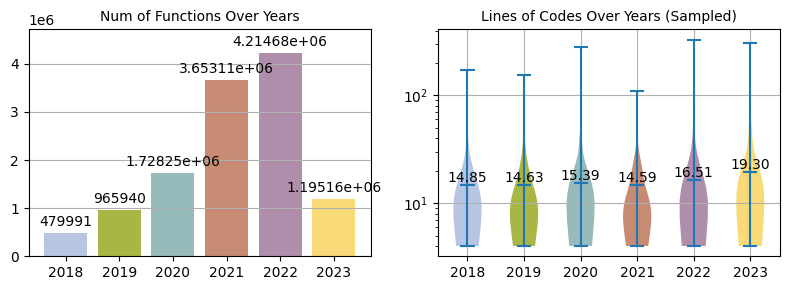

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

years = ['2018', '2019', '2020', '2021', '2022', '2023'] # , '2023-oct'
bar_colors = ['#B7C5E3', '#A9B645', '#97BBBB', '#C78A72', '#AF8EAC', '#F9DA78', '#F9DA78']


#################################################
# plot 1 -- box plot
r, c = 0, 0

# These numbers are based on all data, not the samples in the `data/`` folder.
num_func = [479991, 965940, 1728251, 3653113, 4214679, 1195163]

bars = axs[0].bar(years[:len(num_func)], num_func, color=bar_colors, label=num_func)
axs[0].set_title('Num of Functions Over Years', fontsize=10)
axs[0].bar_label(bars, padding=3, label_type='edge')
axs[0].set_ylim(0, max(num_func) + 500000)

# axs 0
axs[0].yaxis.grid(True)
axs[0].set_xticks([y for y in range(len(num_func))],
                  labels=years[:len(num_func)])


#################################################
# legend for box plot
legend_elements = [Line2D([0], [0], color='darkblue', lw=3, label='median'),
                   Line2D([0], [0], color='deeppink', lw=3, label='mean'),
                   ]

#################################################
# plot 2 
r, c = 0, 1

axs[1].set_title('Lines of Codes Over Years (Sampled)', fontsize=10)


violins = axs[1].violinplot(loc_list,
                  showmeans=True,
                  showmedians=False, 
                  showextrema=True
                  )

for i, pc in enumerate(violins['bodies']):
    pc.set_facecolor(bar_colors[i])
    pc.set_alpha(1)

for i, loc in enumerate(loc_list):
    mean_val = np.mean(loc)
    axs[1].text(i + 1, mean_val, f'{mean_val:.2f}', ha='center', va='bottom', color='black')

axs[1].set_xticks(np.arange(1, len(years) + 1), labels=years)


# adding horizontal grid lines
axs[1].yaxis.grid(True)
axs[1].set_xticks([y + 1 for y in range(len(loc_list))],
                  labels=years)
axs[1].set_yscale('log')

plt.gca().set_ylim(bottom=0.0)
plt.tight_layout()
plt.grid(True)

plt.savefig('../Figure/loc.png')

## Code Complexity

In [ ]:
from code_analysis import quantify_code_complexity, quantify_Cognitive_code_complexity
from data_process import stream_jsonl

data_folder = 'data'

years_in_interest = ['year2018', 'year2019', 'year2020', 'year2021', 'year2022', 'year2023', 'humaneval', 'codereval', 'refactor_if', 'refactor_loop', 'refactor_var-renamer', 'refactor_param', 'refactor_fn-decorator'] 

complexity_list = []
cognitive_complexity_list = []

exception = 0
for year in years_in_interest:
    complexity = []
    cognitive_complexity = []

    question_list = {task['question_id']: task for task in stream_jsonl(f'../{data_folder}/infill_{year}/question.jsonl')}

    for qid in question_list:
        question = question_list[qid]
        code_string = question['content']
        try:
            complexity.append(int(quantify_code_complexity(code_string)))
            cognitive_complexity.append(int(quantify_Cognitive_code_complexity(code_string)))
        except Exception as e:
            # the refactored code is syntactic incorrect. Such cases are rare.
            pass

    complexity_list.append(complexity)
    cognitive_complexity_list.append(cognitive_complexity)

print(len(complexity_list), len(complexity_list[0]))
print(min(cognitive_complexity_list[0]), max(cognitive_complexity_list[0]))


cannot assign to operator (<unknown>, line 7)
def commands_per_day():
    command_names = [row.get('command_name') for row in bigquery_client.query('SELECT DISTINCT command_name FROM analytics.commands').result()]
    print(command_names)
    command_names = filter(lambda item: item not in ['list', 'set', 'voices', 'languages', 'property'], command_names)
    result = {}
    for command_name in command_names:
        usage = {twenty-four_hours: {'text_count': 0, 'slash_count': 0} for twenty-four_hours in get_days_in_range(datetime.datetime(2021, 1, 1), datetime.datetime.today())}
        query = 'SELECT DATE(time) as d, COUNTIF(NOT is_slash) as cnt, COUNTIF(is_slash) as slash_cnt FROM analytics.commands WHERE command_name = @command_name GROUP BY d ORDER BY d'
        job_config = bigquery.QueryJobConfig(query_parameters=[bigquery.ScalarQueryParameter('command_name', 'STRING', command_name)])
        for row in bigquery_client.query(query, job_config=job_config).result():
            d

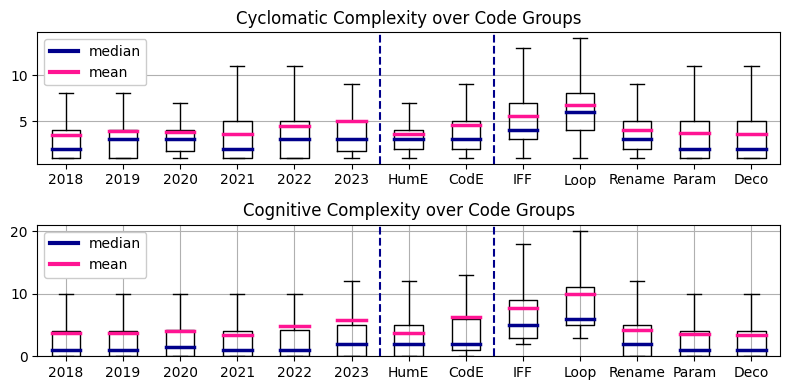

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,4))

legend_elements = [Line2D([0], [0], color='darkblue', lw=3, label='median'),
                   Line2D([0], [0], color='deeppink', lw=3, label='mean'),
                   ]

labels = ['2018', '2019', '2020', '2021', '2022', '2023', 'HumE', 'CodE', 'IFF', 'Loop', 'Rename', 'Param', 'Deco']  


bar_colors = ['#B7C5E3', '#A9B645', '#97BBBB', '#C78A72', '#AF8EAC', '#F9DA78', '#F9DA78']

#################################################
# plot 1
axs[0].set_title('Cyclomatic Complexity over Code Groups', fontsize=12)

# bar
axs[0].boxplot(complexity_list, showfliers=False, medianprops=dict(linestyle='-', linewidth=2.5, color='darkblue'), showmeans=True, meanline=True, meanprops=dict(linestyle='-', linewidth=2.5, color='deeppink'))

axs[0].set_xticks(np.arange(1, len(labels) + 1), labels=labels, fontsize=10)
axs[0].yaxis.grid(True)
axs[0].set_xticks([y + 1 for y in range(len(complexity_list))],
                  labels=labels)
# axs[0].set_yscale('log')

axs[0].legend(handles=legend_elements,  loc='upper left', fancybox=True, framealpha=1.0)

#################################################
# plot 2

axs[1].set_title('Cognitive Complexity over Code Groups', fontsize=12)
axs[1].boxplot(cognitive_complexity_list,  showfliers=False, medianprops=dict(linestyle='-', linewidth=2.5, color='darkblue'), showmeans=True, meanline=True, meanprops=dict(linestyle='-', linewidth=2.5, color='deeppink'))
axs[1].set_xticks(np.arange(1, len(labels) + 1), labels=labels, fontsize=10)
axs[1].yaxis.grid(True)
axs[1].set_xticks([y + 1 for y in range(len(cognitive_complexity_list))],
                  labels=labels)

# axvline set ax
axs[0].axvline(x = 6.5, color = 'darkblue', linestyle = '--', linewidth = 1.5)
axs[0].axvline(x = 8.5, color = 'darkblue', linestyle = '--', linewidth = 1.5)
axs[1].axvline(x = 6.5, color = 'darkblue', linestyle = '--', linewidth = 1.5)
axs[1].axvline(x = 8.5, color = 'darkblue', linestyle = '--', linewidth = 1.5)

axs[1].legend(handles=legend_elements,  loc='upper left', fancybox=True, framealpha=1.0)


plt.gca().set_ylim(bottom=0.0)
plt.tight_layout()
plt.grid(True)
# plt.show()
plt.savefig('../Figure/complexity.png')